# pip install dependencies

In [1]:
!pip install rasterio
!pip install opencv-python
!pip install Pillow
!pip install matplotlib
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# imports

In [3]:
import os
import copy
from pathlib import Path
from itertools import product, chain

import cv2
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull, convex_hull_plot_2d

%matplotlib inline

# process images

In [ ]:
images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Satellite Images"

images_path_dictionary = {}

for path in os.listdir(images_path):
    if path != "desktop.ini":
        for image in os.listdir(os.path.join(images_path, path)):
            images_name_array = []
            if image.endswith("_B3.TIF"):
                image_path = os.path.join(images_path, path, image)
                images_name_array.append(image_path)
                images_name_array.append(image_path.replace("_B3.TIF", "_B5.TIF"))
                images_name_array.append(image_path.replace("_B3.TIF", "_B6.TIF"))
                images_name_array.append(image_path.replace("_B3.TIF", "_B7.TIF"))

                images_path_dictionary[image.replace("_B3.TIF", "")] = images_name_array

In [ ]:
ndwi_dictionary = {}

for i in images_path_dictionary.keys():
    band3 = rasterio.open(images_path_dictionary[i][0])
    band5 = rasterio.open(images_path_dictionary[i][1])
    band6 = rasterio.open(images_path_dictionary[i][2])
    band7 = rasterio.open(images_path_dictionary[i][3])

    green = band3.read(1).astype("float32")
    nir = band5.read(1).astype("float32")
    swir1 = band6.read(1).astype("float32")
    swir2 = band7.read(1).astype("float32")

    ndwi_nir = np.where(
        (green+nir) == 0.,
        0,
        (green-nir)/(green+nir)
    )

    ndwi_swir1 = np.where(
        (green+swir1) == 0.,
        0,
        (green-swir1)/(green+swir1)
    )

    ndwi_swir2 = np.where(
        (green+swir2) == 0.,
        0,
        (green-swir2)/(green+swir2)
    )

    ndwi_nir_copy = copy.copy(ndwi_nir)
    ndwi_nir_copy[ndwi_nir > 0] = -100
    ndwi_nir_copy[ndwi_nir <= 0] = 0

    ndwi_swir1_copy = copy.copy(ndwi_swir1)
    ndwi_swir1_copy[ndwi_swir1 > 0] = -100
    ndwi_swir1_copy[ndwi_swir1 <= 0] = 0

    ndwi_swir2_copy = copy.copy(ndwi_swir2)
    ndwi_swir2_copy[ndwi_swir2 > 0] = -100
    ndwi_swir2_copy[ndwi_swir2 <= 0] = 0

    ndwi_dictionary[i] = [ndwi_nir_copy, ndwi_swir1_copy, ndwi_swir2_copy]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
processed_images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Images"

for m in ndwi_dictionary.keys():
    for n in range(3):
        img = cv2.threshold(
            np.uint8(ndwi_dictionary[m][n]), 0, 255, cv2.THRESH_BINARY)[1]

        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
            img)
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        min_size = 100 * (n+1)

        ndwi_components = np.zeros((output.shape))
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                ndwi_components[output == i + 1] = -100

        if n == 0:
            img_save_path = os.path.join(
                processed_images_path, (m + "_nir" + ".png"))
        elif n == 1:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir1" + ".png"))
        elif n == 2:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir2" + ".png"))

        plt.imsave(img_save_path, ndwi_components, format="png")

In [ ]:
processed_lake_images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Lake Images"

kernel = np.ones((6,6), np.uint8)

for m in ndwi_dictionary.keys():
    for n in range(3):
        if n == 1:
            img = cv2.threshold(
                np.uint8(ndwi_dictionary[m][n]), 0, 255, cv2.THRESH_BINARY)[1]

            img = cv2.erode(img, kernel, iterations=4)
            img = cv2.dilate(img, kernel, iterations=7)

            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
                img)
            sizes = stats[1:, -1]
            nb_components = nb_components - 1

            min_size = 50000

            ndwi_components = np.zeros((output.shape))
            for i in range(0, nb_components):
                if sizes[i] >= min_size:
                    ndwi_components[output == i + 1] = -100

            if n == 0:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_nir" + ".png"))
            elif n == 1:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_swir1" + ".png"))
            elif n == 2:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_swir2" + ".png"))

            plt.imsave(img_save_path, ndwi_components, format="png")

# chain coding on processed edges

In [ ]:
processed_lake_images_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Lake Images"
processed_lake_edges_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Lake Edges"

chains = []
points = []

for path in os.listdir(processed_lake_images_path):
    if path != "desktop.ini":
        image = cv2.imread(os.path.join(processed_lake_images_path, path))
        # image = cv2.resize(image, (1000, 1000))
        image_blur = cv2.GaussianBlur(
            image, (3, 3), 0)
        image_canny = cv2.Canny(image_blur, 240, 250)
        arr_of_ones = []
        for i in range(len(image_canny)):
            for j in range(len(image_canny[i])):
                if image_canny[i][j] != 0:
                    arr_of_ones.append([i, j])


        directions = [
                       0,  1,  2,
                       7,      3,
                       6,  5,  4
                     ]

        dir2idx = dict(zip(directions, range(len(directions))))

        change_j =   [
                       -1,  0,  1, # x or columns
                       -1,      1,
                       -1,  0,  1
                     ]

        change_i =   [
                       -1, -1, -1, # y or rows
                        0,      0,
                        1,  1,  1
                     ]

        border = []
        chain = []
        start_point = arr_of_ones[0]
        curr_point = start_point
        for direction in directions:
            idx = dir2idx[direction]
            new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
            if image_canny[new_point] != 0: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break

        count = 0
        while curr_point != start_point:
            #figure direction to start search
            b_direction = (direction + 5) % 8 
            dirs_1 = range(b_direction, 8)
            dirs_2 = range(0, b_direction)
            dirs = []
            dirs.extend(dirs_1)
            dirs.extend(dirs_2)
            for direction in dirs:
                idx = dir2idx[direction]
                new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
                if image_canny[new_point] != 0: # if is ROI
                    border.append(new_point)
                    chain.append(direction)
                    curr_point = new_point
                    break
            if count == len(arr_of_ones): break
            count += 1

        chains.append(chain)
        points.append(arr_of_ones)

        image_canny = tf.keras.preprocessing.image.img_to_array(image_canny)
        tf.keras.preprocessing.image.save_img(os.path.join(processed_lake_edges_path, path), image_canny)


In [ ]:
np.save("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/chains.npy", chains, allow_pickle=True)
np.save("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/points.npy", points, allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# load points

In [4]:
points = np.load("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/points.npy", allow_pickle=True)

In [5]:
def find_left_most(array):
    array = np.array(array)
    left_most_x = array[np.where(array[:,0] == min(array[:,0]))]
    left_most_y = left_most_x[np.where(left_most_x[:,1] == min(left_most_x[:,1]))]
    return left_most_y[0]

def shift_origin(arrays):
    arrays = arrays
    left_mosts = []
    for array in arrays:
        left_mosts.append(find_left_most(array))

    for i in range(len(arrays)):
        if left_mosts[i].all() == left_mosts[0].all():
            pass
        else:
            shift_x = left_mosts[i][0] - left_mosts[0][0]
            shift_y = left_mosts[i][1] - left_mosts[0][1]
            for j in range(len(arrays[i])):
                arrays[i][j] = [arrays[i][j][0] - shift_x, arrays[i][j][1] - shift_y]
        
    return arrays


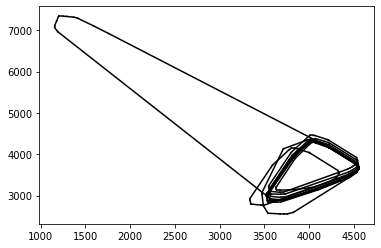

In [28]:
hulls_x = []
hulls_y = []

for points_array in points:
    hull_x = []
    hull_y = []
    points_array = np.array(points_array)
    hull = ConvexHull(points_array)
    for simplex in hull.simplices:
        # print(points_array[simplex, 0], points_array[simplex, 1])
        hull_x.append(points_array[simplex, 0])
        hull_y.append(points_array[simplex, 1])
        plt.plot(points_array[simplex, 0], points_array[simplex, 1], 'k-')
    hulls_x.append(hull_x)
    hulls_y.append(hull_y)


4 20
5 20
6 19
6 20


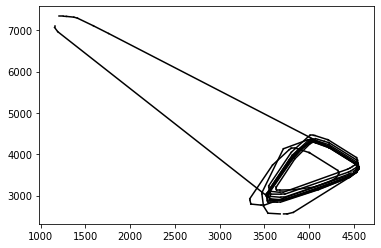

In [31]:
# print(hulls_x)
# print(hulls_y)

for i in range(len(hulls_x)):
    for j in range(len(hulls_x[0])):
        try:
            plt.plot(hulls_x[i][j], hulls_y[i][j], 'k-')
        except:
            print(i,j)

4 20
5 20
6 19
6 20


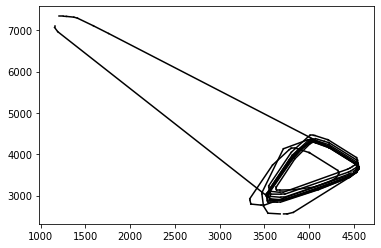

In [33]:
hulls_x = shift_origin(hulls_x)
hulls_y = shift_origin(hulls_y)

for i in range(len(hulls_x)):
    for j in range(len(hulls_x[0])):
        try:
            plt.plot(hulls_x[i][j], hulls_y[i][j], 'k-')
        except:
            print(i,j)

# load chains

In [ ]:
chains = np.load("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/chains.npy", allow_pickle=True)

# DTW

In [ ]:
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
distance, path = fastdtw(chains[0], chains[1], dist=euclidean)

In [ ]:
print(distance, path)

9028.0 [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (1, 17), (2, 18), (3, 19), (4, 20), (5, 21), (6, 22), (7, 23), (8, 24), (9, 25), (10, 26), (11, 27), (12, 28), (13, 29), (14, 30), (15, 31), (16, 32), (17, 33), (18, 34), (19, 35), (20, 36), (21, 37), (22, 38), (23, 39), (24, 40), (25, 41), (26, 42), (27, 43), (28, 44), (29, 45), (30, 46), (31, 47), (32, 48), (33, 49), (34, 50), (35, 51), (36, 52), (36, 53), (36, 54), (36, 55), (36, 56), (36, 57), (36, 58), (36, 59), (36, 60), (36, 61), (36, 62), (36, 63), (36, 64), (36, 65), (36, 66), (36, 67), (36, 68), (36, 69), (36, 70), (36, 71), (36, 72), (36, 73), (36, 74), (36, 75), (36, 76), (36, 77), (36, 78), (36, 79), (36, 80), (36, 81), (36, 82), (36, 83), (37, 84), (38, 85), (39, 86), (40, 87), (40, 88), (40, 89), (40, 90), (40, 91), (40, 92), (40, 93), (40, 94), (40, 95), (40, 96), (40, 97), (40, 98), (40, 99), (40, 100), (40, 101), (40, 1

# chain code differentation

In [ ]:
def chain_analysis(new_chain):
    print("-"*30)

    data_pattern = []

    already_covered = []
    data_current = {}
    count = 0
    for i in range(len(new_chain)-1):
        if new_chain[i] in already_covered:
            data_pattern.append(data_current)
            already_covered = []
            data_current = {}
            count = 1
        else:
            if new_chain[i] == new_chain[i+1]:
                count += 1
            else:
                count += 1

                data_current[new_chain[i]] = count
                already_covered.append(new_chain[i])
                count = 0

    # print("Data :", data_pattern)
    print("Initial Data :", len(data_pattern))

    skip_index = []
    data_pattern_less_than_3 = []
    for i in range(len(data_pattern)):
        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and len(data_pattern[i].values()) <= 3:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_less_than_3.append({pos: out})
            else:
                data_pattern_less_than_3.append(data_pattern[i])
        else:
            data_pattern_less_than_3.append(data_pattern[i])


    # print("Data with spikes less than 3 normalized :", data_pattern_less_than_3)
    print("Data with spikes less than 3 normalized :", len(data_pattern_less_than_3))

    skip_index = []
    data_pattern_range_1 = []
    for i in range(len(data_pattern)):
        arr = []
        for j in range(len(data_pattern[i].keys())):
            if j != list(data_pattern[i].values()).index(max(data_pattern[i].values())):
                mul = data_pattern[i][list(data_pattern[i].keys())[j]] * list(data_pattern[i].keys())[j]
                arr.append(mul)

        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and -1 <= (sum(arr) % 8) <= 1:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_range_1.append({pos: out})
            else:
                data_pattern_range_1.append(data_pattern[i])
        else:
            data_pattern_range_1.append(data_pattern[i])

    # print("Data with spikes resultant between -1, 1 normalized :", data_pattern_range_1)
    print("Data with spikes resultant between -1, 1 normalized :", len(data_pattern_range_1))

    skip_index = []
    data_pattern_exact_0 = []
    for i in range(len(data_pattern)):
        arr = []
        for j in range(len(data_pattern[i].keys())):
            if j != list(data_pattern[i].values()).index(max(data_pattern[i].values())):
                mul = data_pattern[i][list(data_pattern[i].keys())[j]] * list(data_pattern[i].keys())[j]
                arr.append(mul)

        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and sum(arr) == 0:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_exact_0.append({pos: out})
            else:
                data_pattern_exact_0.append(data_pattern[i])
        else:
            data_pattern_exact_0.append(data_pattern[i])

    # print("Data with spikes resultant to be normalized :", data_pattern_exact_0)
    print("Data with spikes resultant to be normalized :", len(data_pattern_exact_0))

    print("-"*30)

    return data_pattern, data_pattern_less_than_3, data_pattern_range_1, data_pattern_exact_0
    

In [ ]:
arr_for_hists_for_data_pattern = []
arr_for_hists_for_data_pattern_less_than_3 = []
arr_for_hists_for_data_pattern_range_1 = []
arr_for_hists_for_data_pattern_exact_0 = []


for chain in chains:
    # new_chain = []
    # for i in range(len(chain)):
    #     new_chain.append(chain[i]-chain[(i+1)%len(chain)])

    new_chain = chain
    data_pattern, data_pattern_less_than_3, data_pattern_range_1, data_pattern_exact_0 = chain_analysis(new_chain)
    
    arr_for_hist_data_pattern = []
    arr_for_hist_data_pattern_less_than_3 = []
    arr_for_hist_data_pattern_range_1 = []
    arr_for_hist_data_pattern_exact_0 = []

    for i in data_pattern:
        arr_for_hist_data_pattern.append(max(i.values()))

    for i in data_pattern_less_than_3:
        arr_for_hist_data_pattern_less_than_3.append(max(i.values()))

    for i in data_pattern_range_1:
        arr_for_hist_data_pattern_range_1.append(max(i.values()))

    for i in data_pattern_exact_0:
        arr_for_hist_data_pattern_exact_0.append(max(i.values()))

    arr_for_hists_for_data_pattern.append(arr_for_hist_data_pattern)
    arr_for_hists_for_data_pattern_less_than_3.append(arr_for_hist_data_pattern_less_than_3)
    arr_for_hists_for_data_pattern_range_1.append(arr_for_hist_data_pattern_range_1)
    arr_for_hists_for_data_pattern_exact_0.append(arr_for_hist_data_pattern_exact_0)


------------------------------
Initial Data : 692
Data with spikes less than 3 normalized : 607
Data with spikes resultant between -1, 1 normalized : 674
Data with spikes resultant to be normalized : 692
------------------------------
------------------------------
Initial Data : 1320
Data with spikes less than 3 normalized : 1214
Data with spikes resultant between -1, 1 normalized : 1287
Data with spikes resultant to be normalized : 1301
------------------------------
------------------------------
Initial Data : 545
Data with spikes less than 3 normalized : 474
Data with spikes resultant between -1, 1 normalized : 514
Data with spikes resultant to be normalized : 530
------------------------------
------------------------------
Initial Data : 668
Data with spikes less than 3 normalized : 590
Data with spikes resultant between -1, 1 normalized : 624
Data with spikes resultant to be normalized : 645
------------------------------
------------------------------
Initial Data : 882
Data w

# histogram

(array([[5.480e+02, 5.000e+01, 3.500e+01, 4.000e+01, 1.700e+01, 2.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.155e+03, 6.400e+01, 1.900e+01, 2.300e+01, 4.500e+01, 1.000e+01,
         4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.050e+02, 4.200e+01, 1.900e+01, 4.100e+01, 2.500e+01, 1.000e+01,
         1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00],
        [5.160e+02, 5.700e+01, 3.500e+01, 3.600e+01, 1.300e+01, 1.100e+01,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [7.460e+02, 7.100e+01, 2.700e+01, 2.000e+01, 1.800e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.380e+02, 4.700e+01, 1.500e+01, 4.000e+01, 3.000e+01, 6.000e+00,
         3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00],
        [4.940e+02, 1.100e+01, 3.700e+01, 5.100e+01, 6.000e+00, 5.000e+00,
         5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [8.390e+02, 4.300e+01, 2.500e+01, 5.100e+01, 8.000e+00, 0.000e+00,
         0.000e+00, 0.

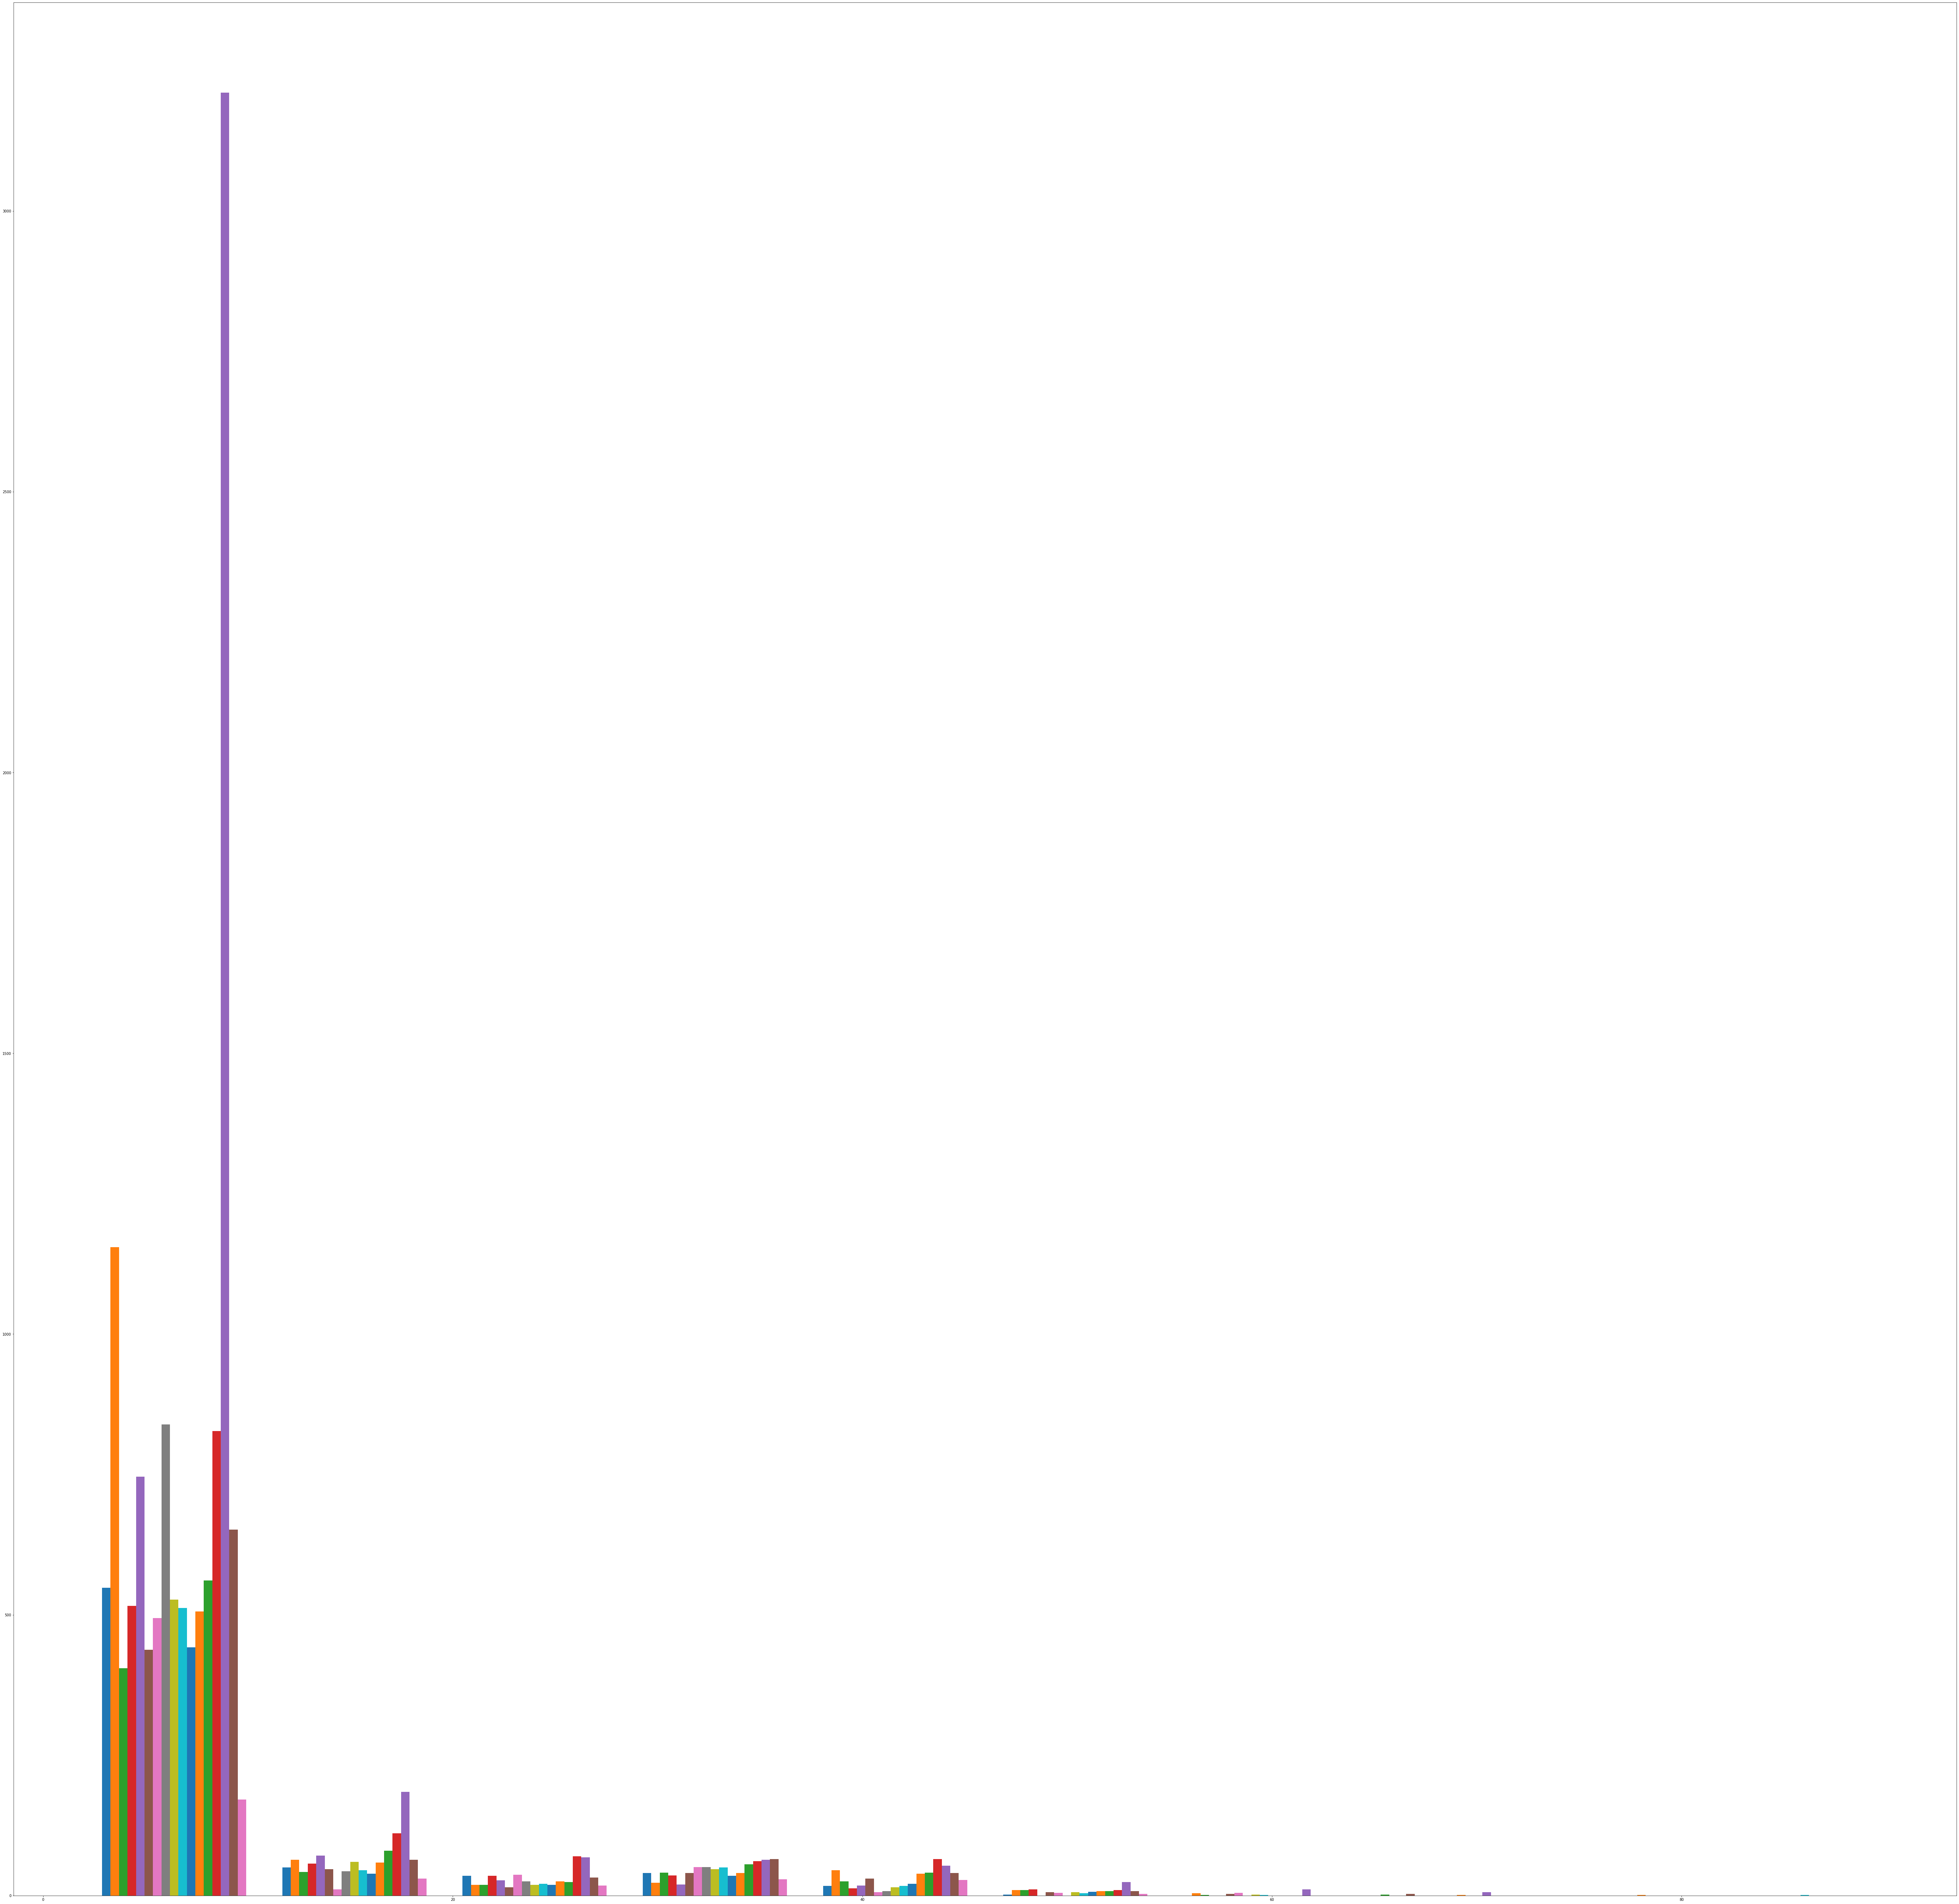

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern)

(array([[5.000e+02, 3.400e+01, 5.500e+01, 8.000e+00, 7.000e+00, 3.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.079e+03, 4.600e+01, 3.400e+01, 4.700e+01, 0.000e+00, 8.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.610e+02, 3.300e+01, 4.000e+01, 2.900e+01, 5.000e+00, 4.000e+00,
         2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.790e+02, 3.200e+01, 5.500e+01, 2.000e+01, 4.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [6.540e+02, 6.400e+01, 3.400e+01, 2.300e+01, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.910e+02, 3.400e+01, 4.300e+01, 1.900e+01, 6.000e+00, 4.000e+00,
         7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.600e+02, 1.500e+01, 6.300e+01, 1.100e+01, 1.000e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [7.870e+02, 3.400e+01, 5.100e+01, 1.300e+01, 4.000e+00, 0.000e+00,
         0.000e+00, 0.

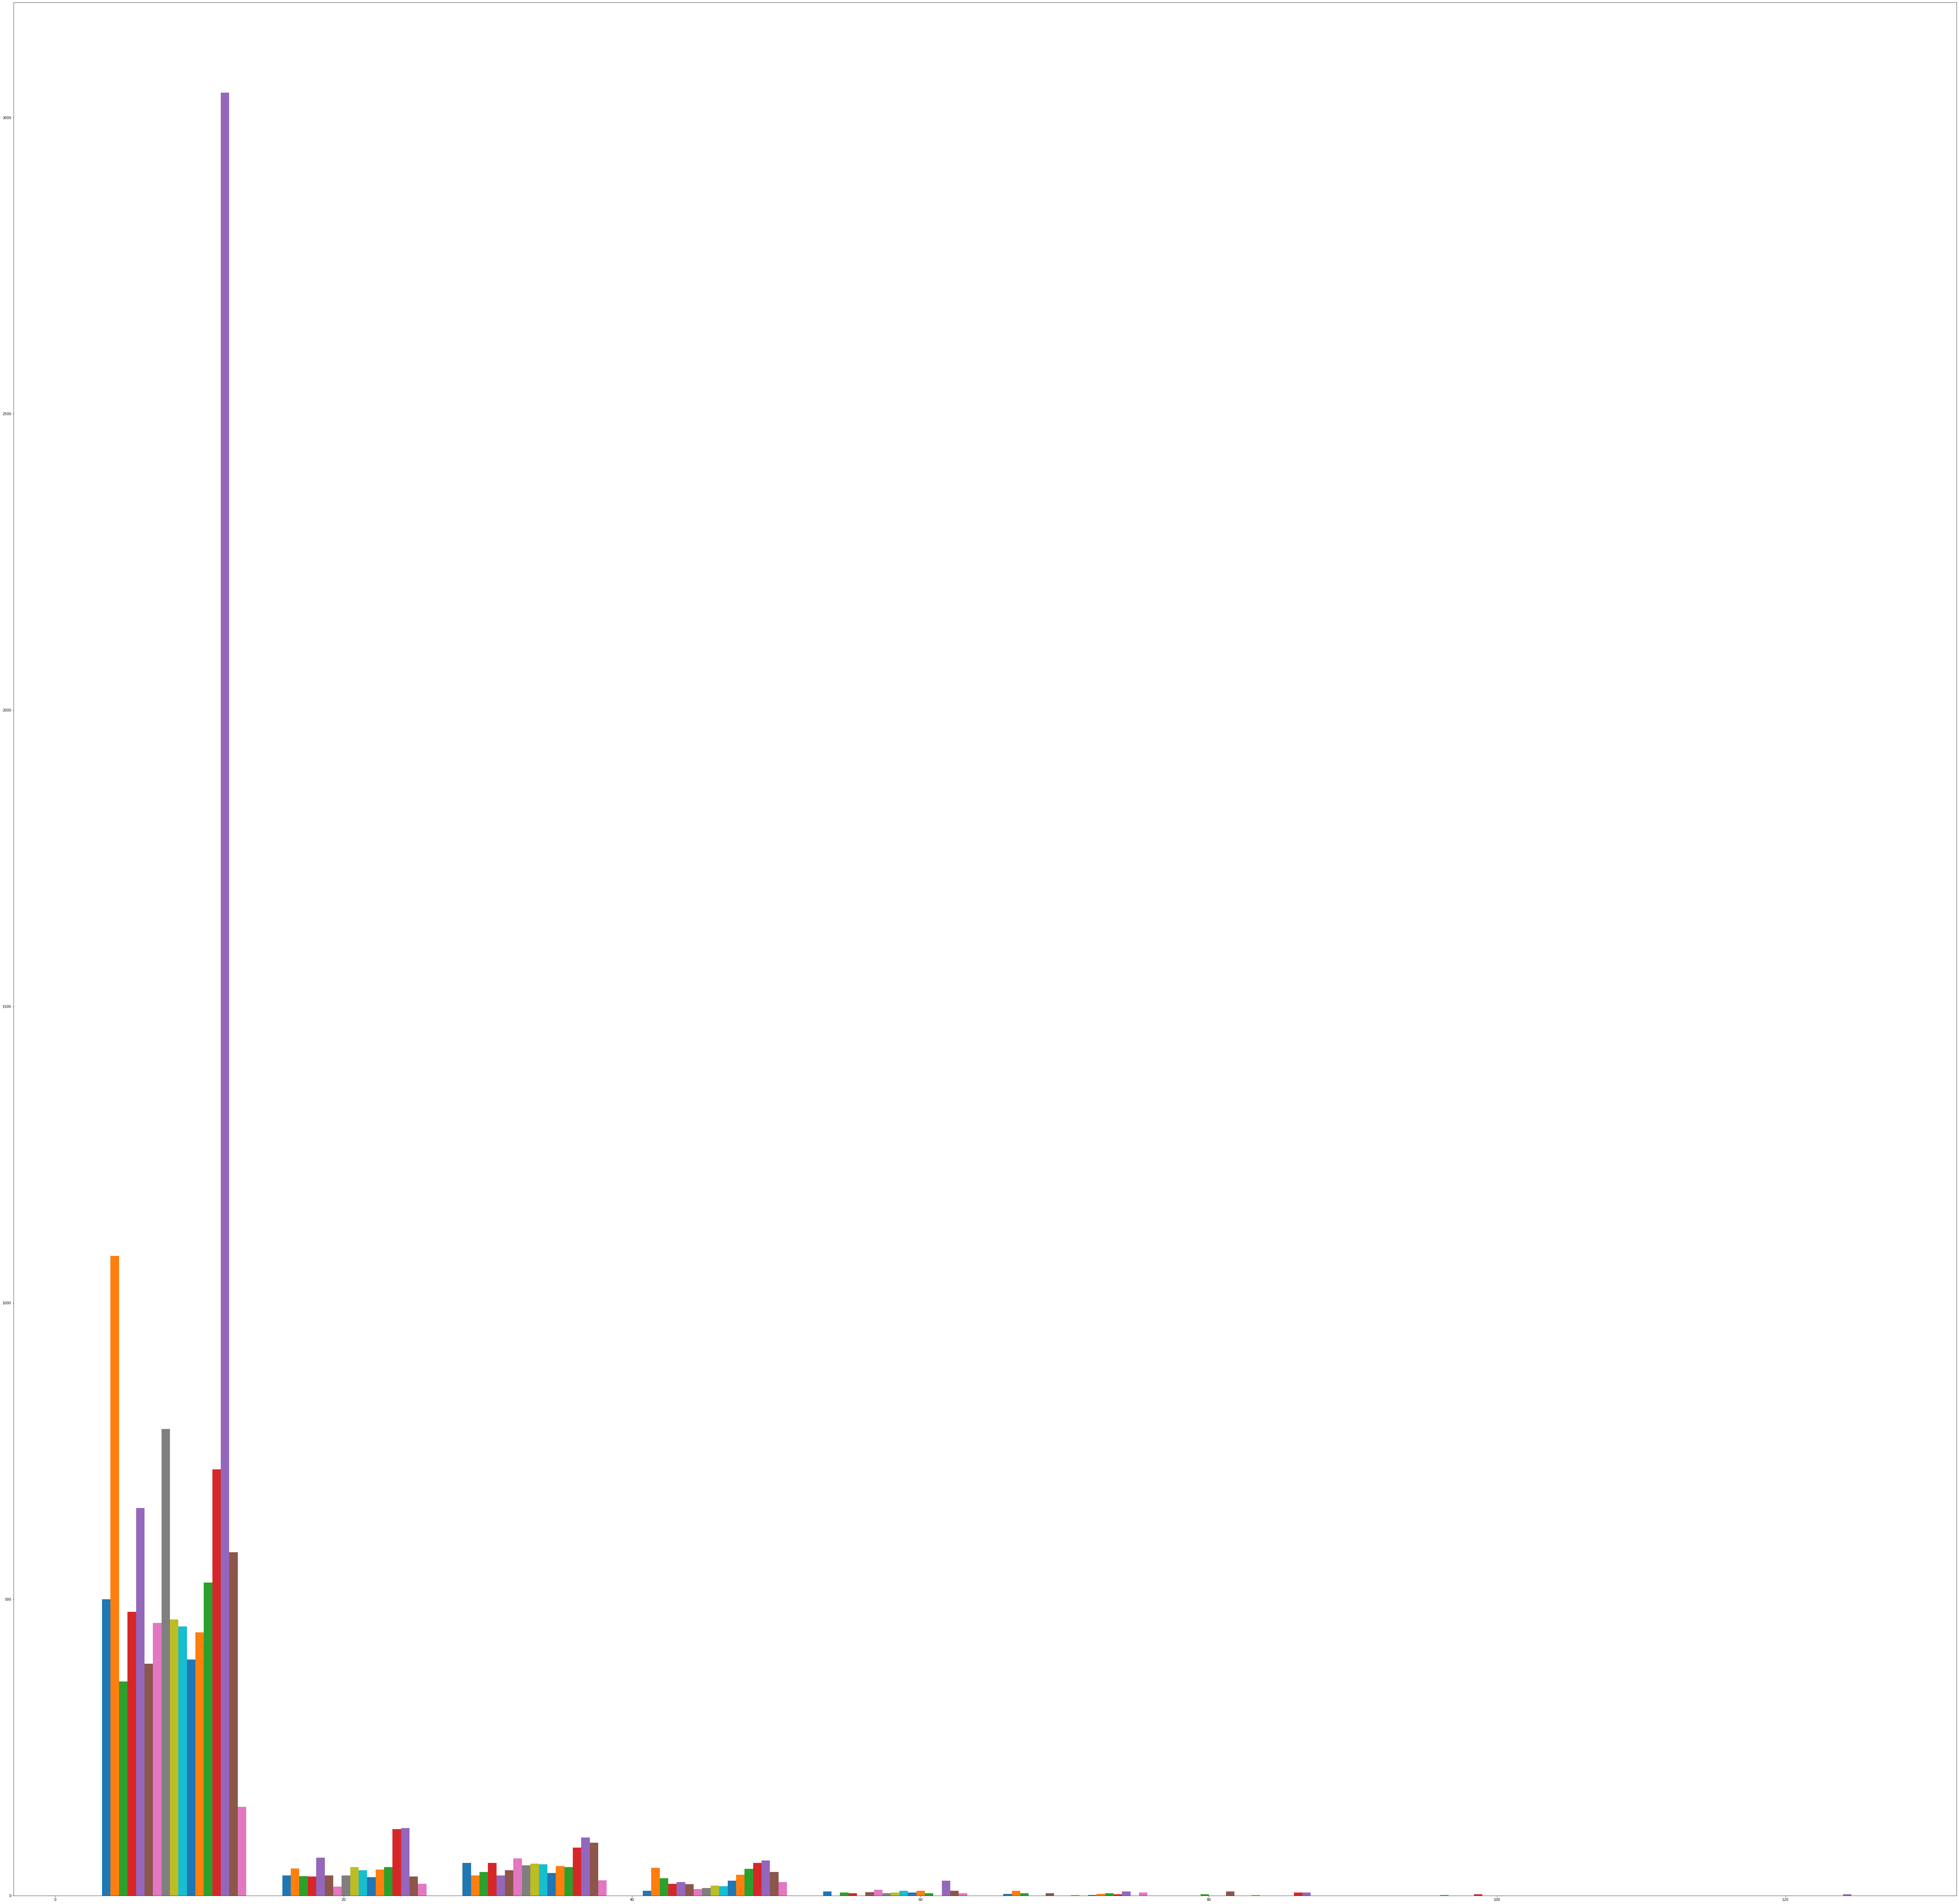

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_less_than_3)

(array([[5.340e+02, 4.900e+01, 2.900e+01, 4.000e+01, 1.500e+01, 2.000e+00,
         4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
        [1.122e+03, 6.700e+01, 1.900e+01, 2.000e+01, 3.800e+01, 1.700e+01,
         4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.830e+02, 3.400e+01, 1.600e+01, 4.100e+01, 2.200e+01, 1.200e+01,
         3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00],
        [4.770e+02, 4.900e+01, 3.200e+01, 4.100e+01, 1.100e+01, 1.300e+01,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [6.690e+02, 8.000e+01, 2.700e+01, 1.500e+01, 2.300e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.150e+02, 4.000e+01, 1.900e+01, 3.700e+01, 2.800e+01, 6.000e+00,
         4.000e+00, 3.000e+00, 2.000e+00, 0.000e+00],
        [4.720e+02, 1.100e+01, 3.100e+01, 5.100e+01, 1.200e+01, 5.000e+00,
         5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [8.090e+02, 4.300e+01, 1.600e+01, 6.000e+01, 8.000e+00, 0.000e+00,
         0.000e+00, 0.

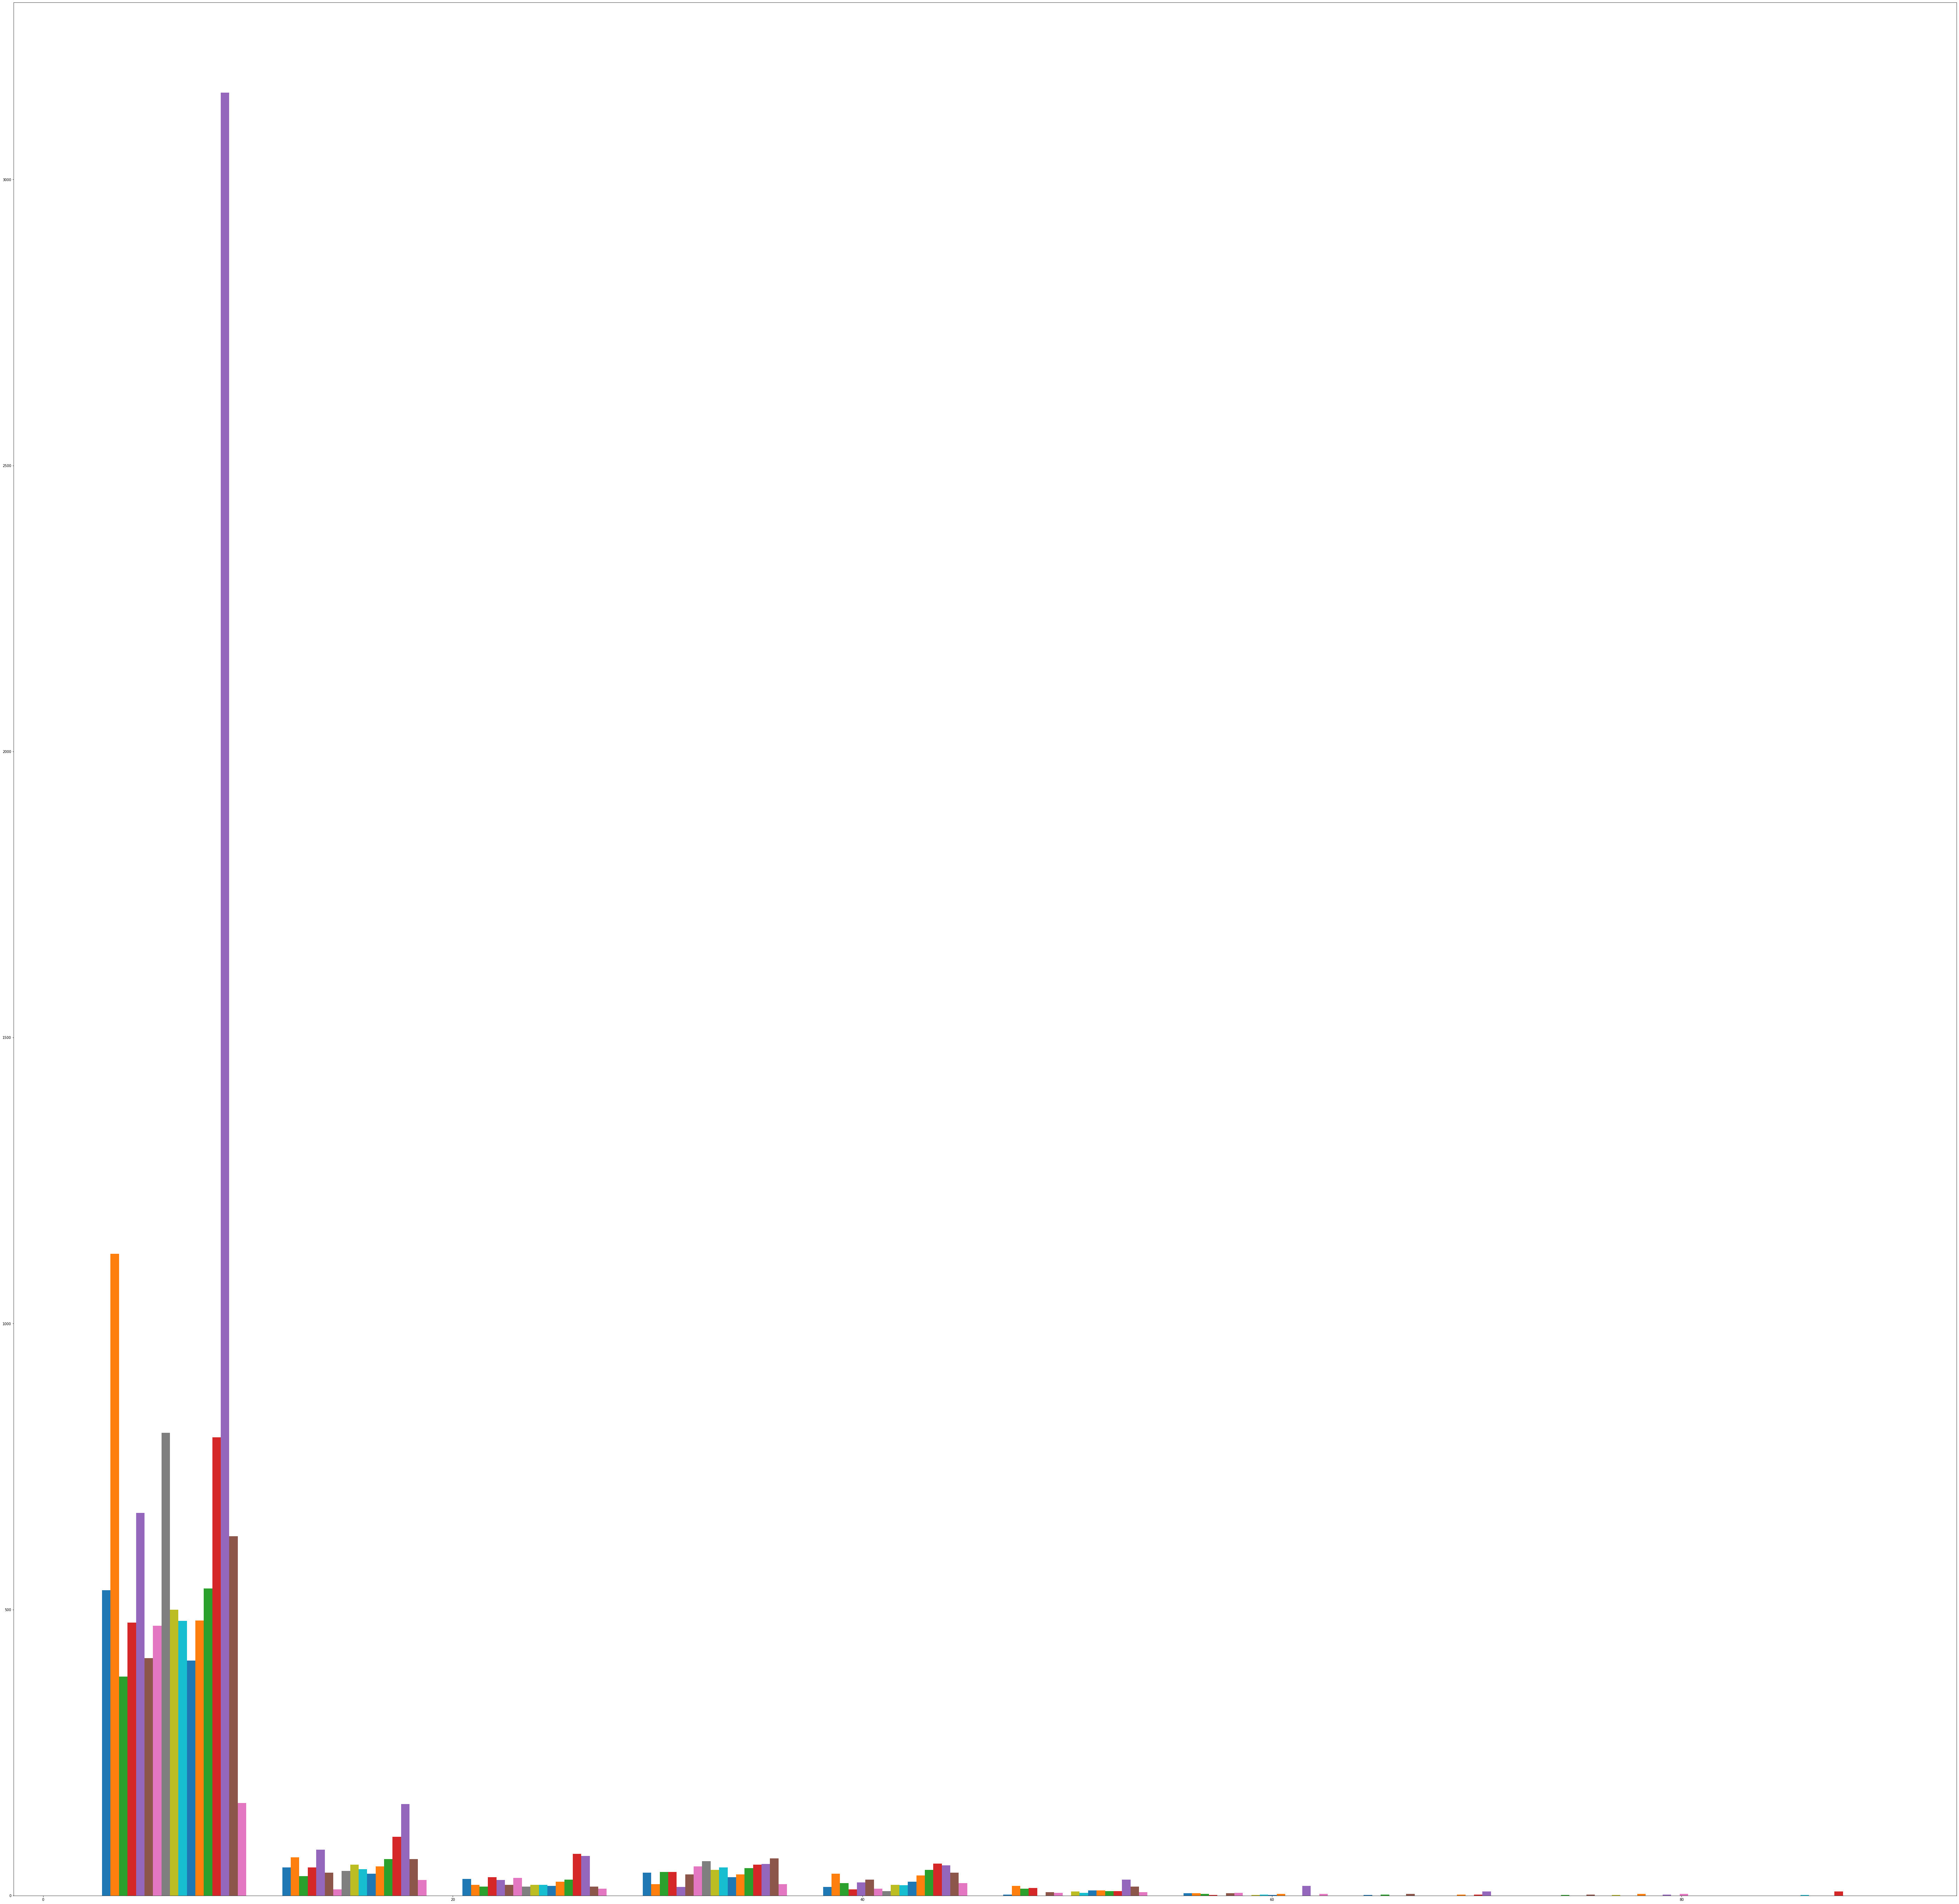

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_range_1)

(array([[5.480e+02, 5.000e+01, 3.500e+01, 4.000e+01, 1.700e+01, 2.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.136e+03, 6.400e+01, 1.900e+01, 2.300e+01, 4.100e+01, 1.400e+01,
         4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.920e+02, 3.900e+01, 1.800e+01, 4.100e+01, 2.400e+01, 1.200e+01,
         2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00],
        [4.960e+02, 5.100e+01, 3.500e+01, 3.800e+01, 1.400e+01, 1.100e+01,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [7.000e+02, 8.000e+01, 2.700e+01, 2.000e+01, 1.800e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.250e+02, 4.200e+01, 1.700e+01, 4.100e+01, 2.900e+01, 6.000e+00,
         4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00],
        [4.880e+02, 1.100e+01, 3.100e+01, 5.700e+01, 6.000e+00, 5.000e+00,
         5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [8.230e+02, 4.300e+01, 2.100e+01, 5.500e+01, 8.000e+00, 0.000e+00,
         0.000e+00, 0.

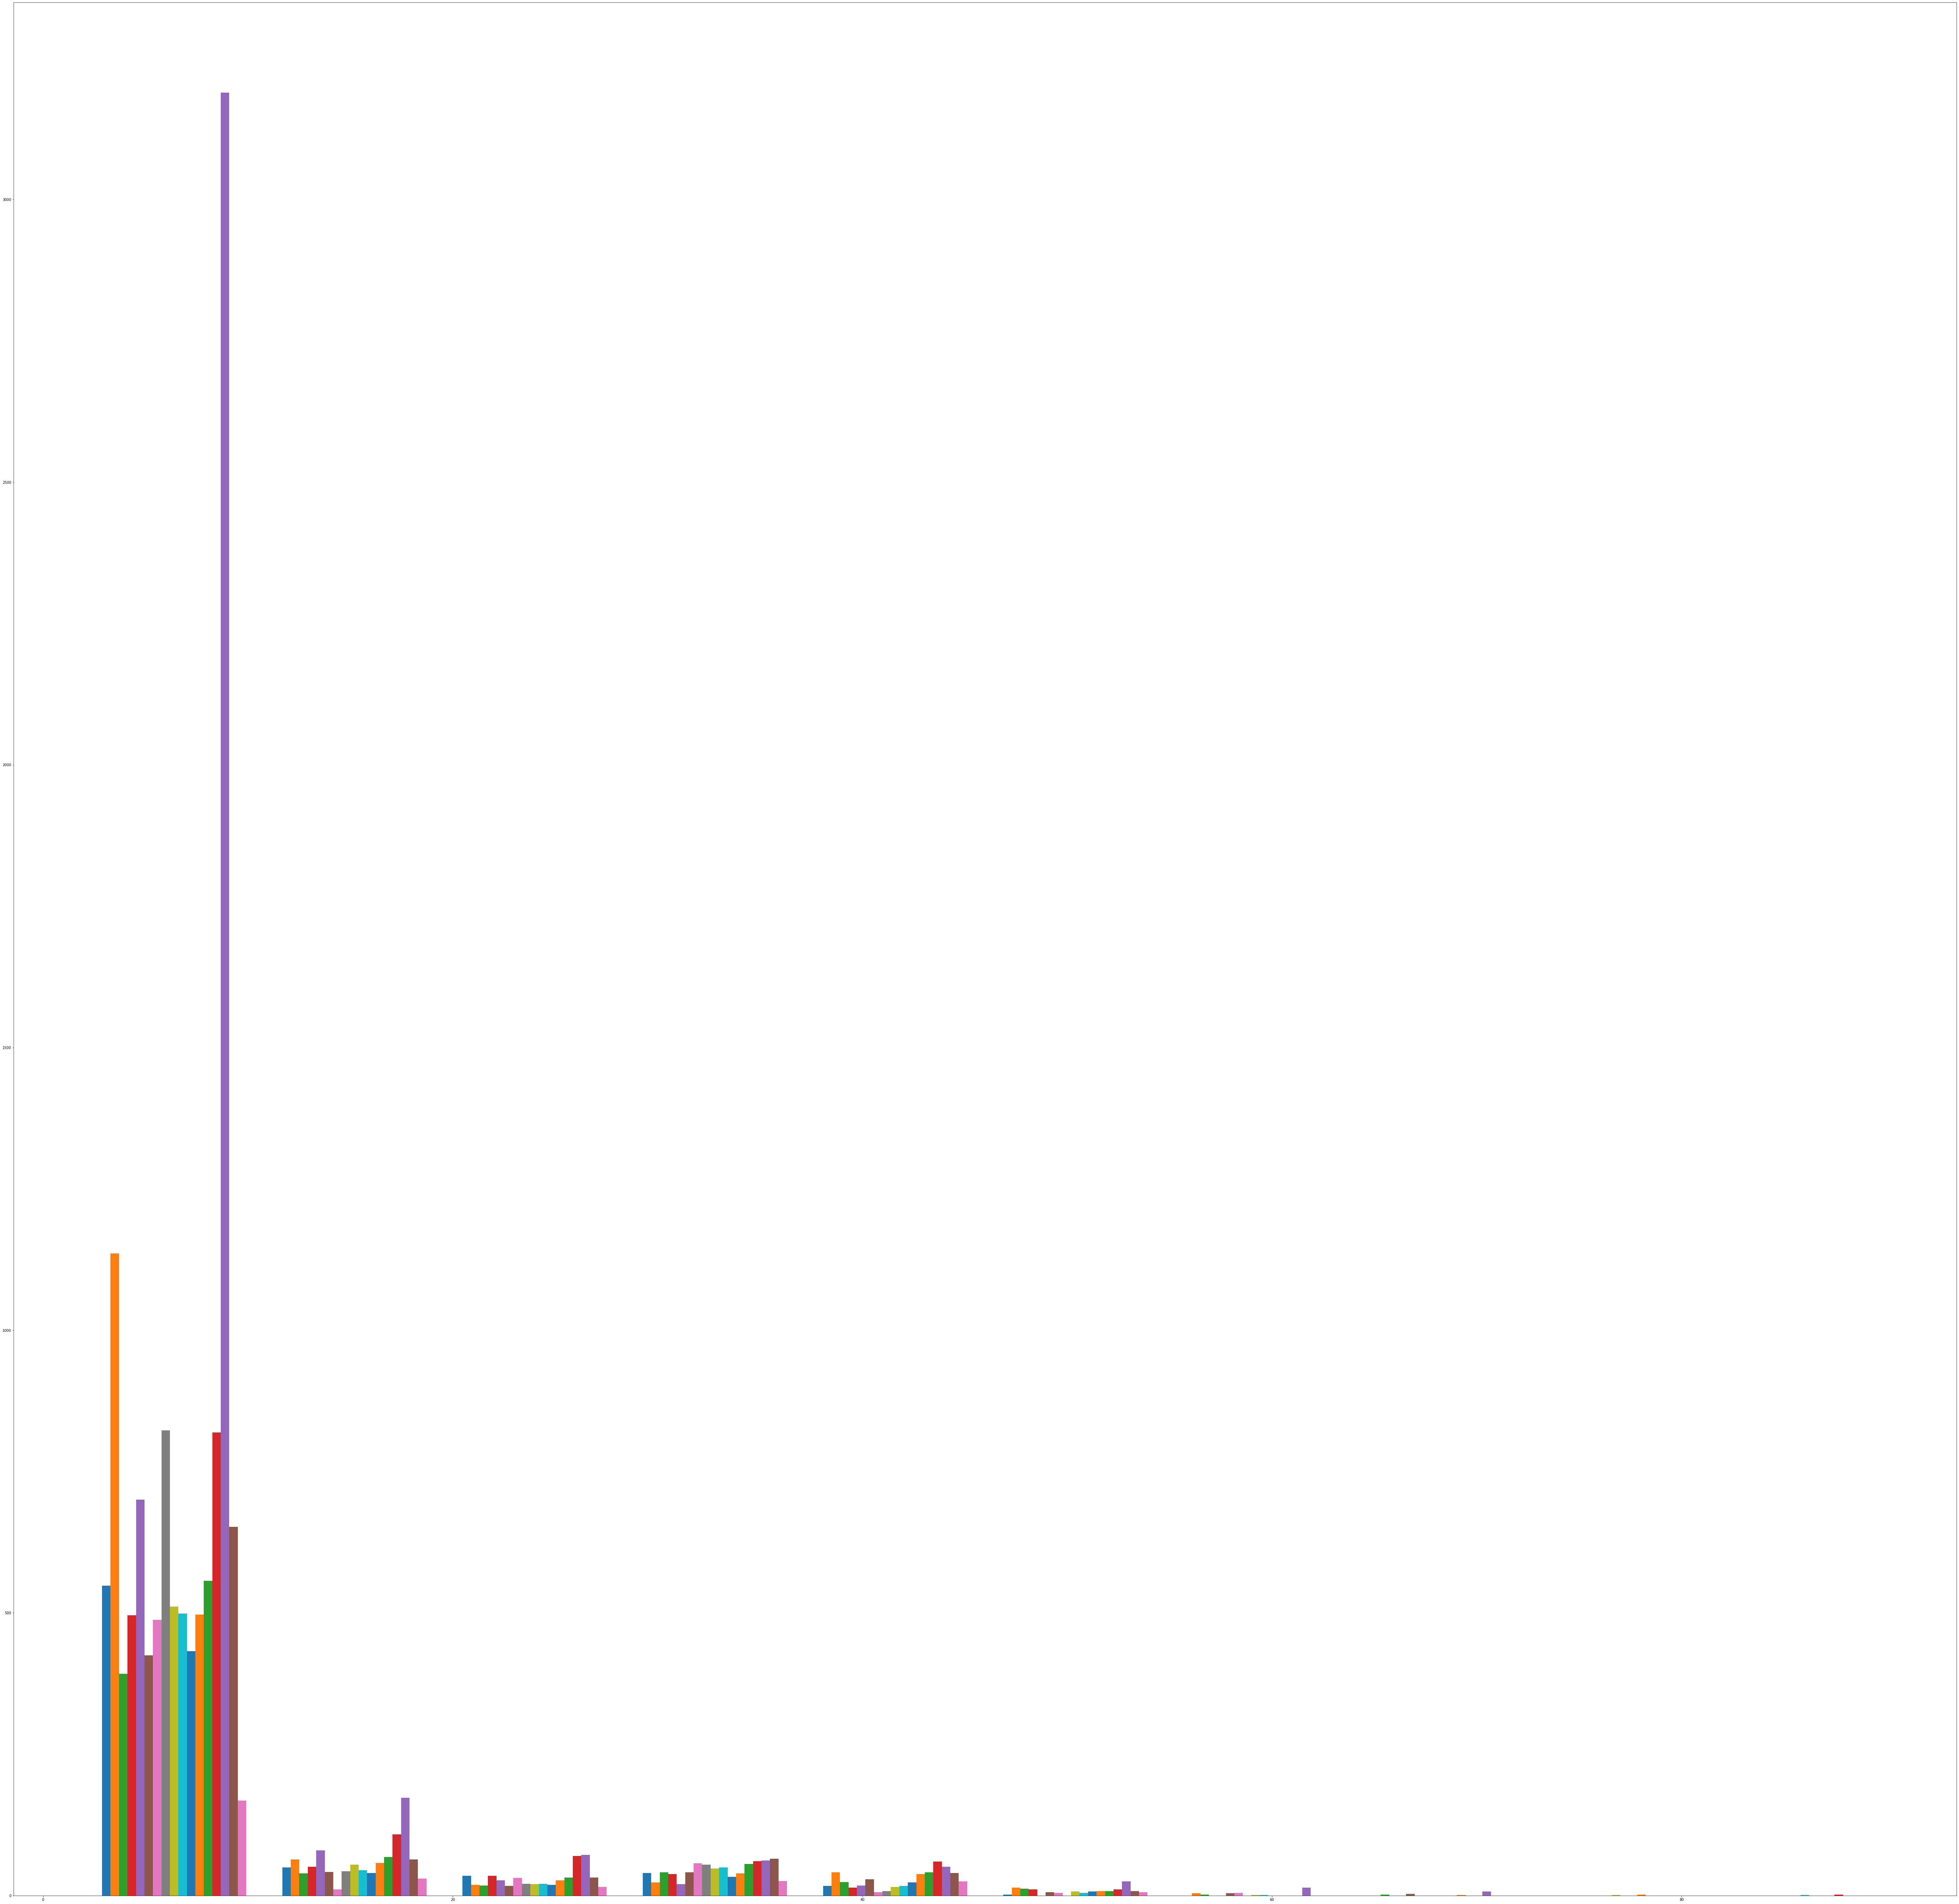

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_exact_0)

# crop images in to sections

In [ ]:
dh = 1024
dw = 1024

for image in os.listdir(processed_images_path):
    name, ext = os.path.splitext(image)
    img = Image.open(os.path.join(processed_images_path, image))
    w, h = img.size

    grid = product(range(0, h-(h % dh), dh), range(0, w-(w % dw), dw))
    for i, j in grid:
        if j+dw <= w:
            box = (j, i, j+dw, i+dh)
            out = os.path.join(
                "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Cropped/", f'{name}{j}x{i}_{j+dw}x{i+dh}{ext}')
            cropped_img = img.crop(box)
            np_cropped_img = np.asarray(cropped_img)
            print()
            if np.all(np_cropped_img == np_cropped_img[0]):
                continue
            else:
                cropped_img.save(out)

OSError: ignored